# 17 - Gerando dados sinteticos e verificando se existe over ou under fit

In [1]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [2]:
# Gerando um dataset com 2 variáveis, 200 caracteristicas e 1000 amostras
x,y = make_classification(n_samples=1000, n_features=200, n_informative=3, n_redundant=10, n_classes=2, n_clusters_per_class=2,weights=None, flip_y=0.01,class_sep=0.8,
hypercube=True, shift=0.0, scale = 1.0,shuffle=True, random_state=1)

print(x.shape)
print(y.shape)

(1000, 200)
(1000,)


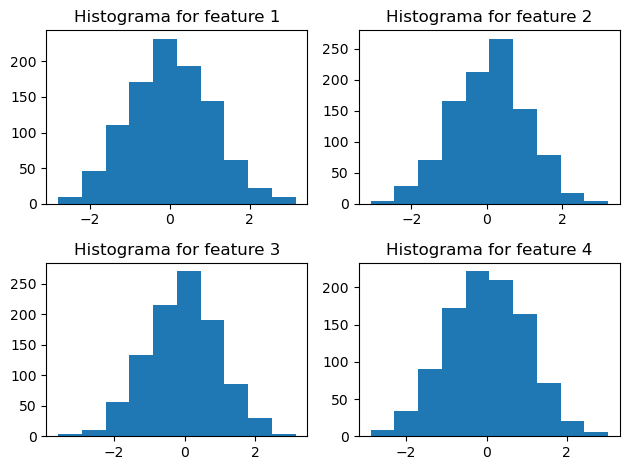

In [3]:
# As primeiras caracteristicas como histograma para mostrar que o intervalo de valores é o mesmo.
# Está na mesma escala, ou seja, precisa normalizar alguma variável?
for plot_index in range(4):
    plt.subplot(2,2,plot_index+1)
    plt.hist(x[:,plot_index])
    plt.title('Histograma for feature {}'.format(plot_index+1))
plt.tight_layout()

#### Outras preocupações que devemos ter:

    1) Os dados estão balanceados em termos das frações de classes da variáveç de resposta? Se sim, não precisamos aumentar ou diminuir as amostras, ou usar outros métodos úteis para dados desbalanceados

    2) As caracteristicas tem ligação com a variável resposta?

In [4]:
x_treino, x_teste, y_treino, y_teste = train_test_split(x,y,test_size=0.2, random_state=1)
lr = LogisticRegression(solver='liblinear', penalty='l1', C = 1000, random_state=1)
lr.fit(x_treino, y_treino)

LogisticRegression(C=1000, penalty='l1', random_state=1, solver='liblinear')

In [5]:
# Identificando se existe um sobreajuste ou subajuste:

train_pred = lr.predict_proba(x_treino)
test_pred = lr.predict_proba(x_teste)

print('ROCAUC Treino: {}'.format(roc_auc_score(y_score=train_pred[:,1], y_true = y_treino)))
print('ROCAUC Teste: {}'.format(roc_auc_score(y_score=test_pred[:,1], y_true =  y_teste)))

# O resultado do treino está sendo maior que o do teste, ou seja, um overfit (sobreajuste)...

ROCAUC Treino: 0.9642776777677768
ROCAUC Teste: 0.8666466586634654


# 18  -  Reduzindo o overfitting

In [6]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve

In [24]:
# Criando um array com os valores que serão testados
c_val_expoente = np.linspace(3,-3,13)
c_val = np.float64(10)**c_val_expoente

fold = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)

In [28]:
def cross_val_c_search(n_folds, C_vals, model, X, Y):
    
    # Ajustando as informações
    cv_train_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc = [[]]*len(C_vals)

    for c_val_counter in range(len(C_vals)):
        #Set the C value for the model object
        model.C = C_vals[c_val_counter]
        #Count folds for each value of C
        fold_counter = 0
        #Get training and testing indices for each fold
        for train_index, test_index in k_folds.split(X, Y):
            #Subset the features and response, for training and testing data for
            #this fold
            X_cv_train, X_cv_test = X[train_index], X[test_index]
            y_cv_train, y_cv_test = Y[train_index], Y[test_index]

            #Fit the model on the training data
            model.fit(X_cv_train, y_cv_train)

            #Get the training ROC AUC
            y_cv_train_predict_proba = model.predict_proba(X_cv_train)
            cv_train_roc_auc[fold_counter, c_val_counter] = \
            roc_auc_score(y_cv_train, y_cv_train_predict_proba[:,1])

            #Get the testing ROC AUC
            y_cv_test_predict_proba = model.predict_proba(X_cv_test)
            cv_test_roc_auc[fold_counter, c_val_counter] = \
            roc_auc_score(y_cv_test, y_cv_test_predict_proba[:,1])

            #Testing ROC curves for each fold
            this_fold_roc = roc_curve(y_cv_test, y_cv_test_predict_proba[:,1])
            cv_test_roc[c_val_counter].append(this_fold_roc)

            #Increment the fold counter
            fold_counter += 1

        #Indicate progress
        print('Done with C = {}'.format(lr.C))

    return cv_train_roc_auc, cv_test_roc_auc, cv_test_roc

In [29]:
# Utilizando a função em foco
cv_train_roc_auc, cv_teste_roc_auc, cv_teste_roc = cross_val_c_search(n_folds=4, C_vals=c_val, model=lr, X=x, Y=y)

C:\Users\joaom\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Done with C = 1000.0


C:\Users\joaom\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Done with C = 316.22776601683796


C:\Users\joaom\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Done with C = 100.0
Done with C = 31.622776601683793
Done with C = 10.0
Done with C = 3.1622776601683795
Done with C = 1.0
Done with C = 0.31622776601683794
Done with C = 0.1
Done with C = 0.03162277660168379
Done with C = 0.01
Done with C = 0.0031622776601683794
Done with C = 0.001


Text(0.5, 1.0, 'CV medio dos folds')

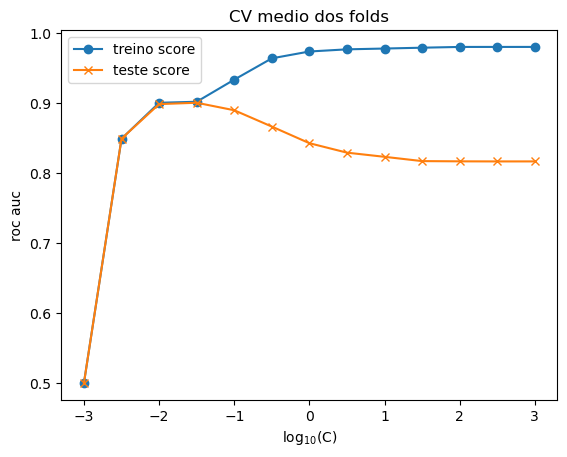

In [35]:
# A melhor forma de analisar o melhor valor do parametro em foco é atraves das médias do folds utilizando o roc auc
# No gráfico a seguir podese analisar que o melhhor valor para o parametro C da modelo de regressão logistica é algum valor entre -2 e -1 (elevado)...

plt.plot(c_val_expoente, np.mean(cv_train_roc_auc, axis=0), '-o', label='treino score')
plt.plot(c_val_expoente, np.mean(cv_teste_roc_auc, axis=0), '-x', label='teste score')
plt.ylabel('roc auc')
plt.xlabel('log$_{10}$(C)')
plt.legend()
plt.title('CV medio dos folds')

## Analisando a taxa de TPV e FPV

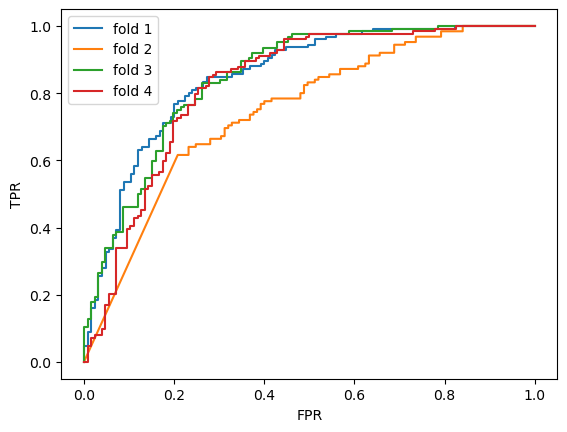

In [41]:
# Provavelmente o melhor valor para o parametro C é algum valor entre -2 e -1, porém, será que o modelo está classificando bem os TPV e FPV?
# Basicamente usamos isso para analisar o resultado dos folds

# Para isso, vamos... Selecionar o valor intermediario entre esse 2 valores, ou seja, -1.5. Temos que aplicar uma mascara.
melhor_c = c_val_expoente == -1.5
i_melhor_c = np.nonzero(melhor_c.astype(int))

for this_fold in range(4):
    fpr = cv_teste_roc[i_melhor_c[0][0]][this_fold][0]
    tpr = cv_teste_roc[i_melhor_c[0][0]][this_fold][1]
    plt.plot(fpr, tpr, label = f'fold {this_fold+1}')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

## Retreinando o modelo com o novo parametro (Tunagem do modelo)

In [42]:
new_lr = LogisticRegression(solver='liblinear', penalty='l1', random_state=1)
new_lr.C = 10**(-1.5)
new_lr.fit(x_treino, y_treino)

LogisticRegression(C=0.03162277660168379, penalty='l1', random_state=1,
                   solver='liblinear')

In [45]:
# Overfitado ou underfitado?

# Treino
y_new_lr_pred_treino = new_lr.predict_proba(x_treino)
print('TREINO:', roc_auc_score(y_treino, y_new_lr_pred_treino[:,1]))

# Teste
y_new_lr_pred_teste = new_lr.predict_proba(x_teste)
print('TESTE:', roc_auc_score(y_teste, y_new_lr_pred_teste[:,1]))

# Se os valores estão próximos, isso significa que o modelo está ajustado e pronto para encarar dados desconhecidos

TREINO: 0.9009588458845884
TESTE 0.9072629051620649
